In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [3]:
covid_df = pd.read_csv('penn_multi_df.csv', parse_dates=['Date'])
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].diff()
covid_df.fillna(0, inplace=True)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_df.set_index('ds', inplace=True)

train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [4]:
covid_train = covid_train[['y', 'new_cases_350_lag', 'new_cases_10_std', 'new_deaths_3_lag', 'relative_humidity', 'new_hospitalized_patients', 'current_intensive_care_patients', 'new_cases_150_lag', 'new_cases_7_lag', 'new_cases_4_lag', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_30_lag', 'new_cases_10_min', 'new_cases_1 lag', 'new_cases_3_lag', 'new_deaths_4_lag', 'new_deaths_1_lag', 'new_cases_50_std', 'new_cases_10_max', 'new_cases_10_mean']]
covid_test = covid_test[['y', 'new_cases_350_lag', 'new_cases_10_std', 'new_deaths_3_lag', 'relative_humidity', 'new_hospitalized_patients', 'current_intensive_care_patients', 'new_cases_150_lag', 'new_cases_7_lag', 'new_cases_4_lag', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_30_lag', 'new_cases_10_min', 'new_cases_1 lag', 'new_cases_3_lag', 'new_deaths_4_lag', 'new_deaths_1_lag', 'new_cases_50_std', 'new_cases_10_max', 'new_cases_10_mean']]


In [5]:
X_train = covid_train.drop(columns=['y'], axis=1)
y_train = covid_train['y']
X_test = covid_test.drop(columns=['y'], axis=1)
y_test = covid_test['y']

In [17]:
reg_model = xgb.XGBRegressor(learning_rate=0.1,n_estimators=10000, early_stopping_rounds=10)
reg_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[0]	validation_0-rmse:1316.13352	validation_1-rmse:2938.67601
[1]	validation_0-rmse:1260.32719	validation_1-rmse:2951.30443
[2]	validation_0-rmse:1220.16222	validation_1-rmse:2980.26647
[3]	validation_0-rmse:1174.06288	validation_1-rmse:3034.79029
[4]	validation_0-rmse:1123.13642	validation_1-rmse:3101.49941
[5]	validation_0-rmse:1083.87008	validation_1-rmse:3184.26911
[6]	validation_0-rmse:1044.21628	validation_1-rmse:3281.93262
[7]	validation_0-rmse:1010.63608	validation_1-rmse:3381.49022
[8]	validation_0-rmse:970.13318	validation_1-rmse:3485.53979
[9]	validation_0-rmse:941.88043	validation_1-rmse:3593.84789


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

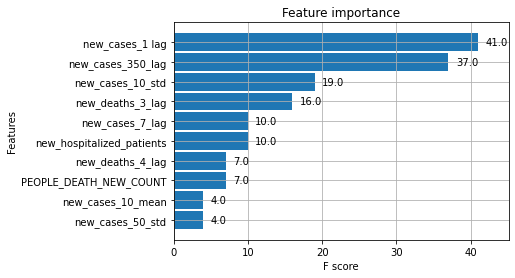

In [18]:
_ = plot_importance(reg_model, height=0.9 ,max_num_features = 10)

<AxesSubplot:xlabel='ds'>

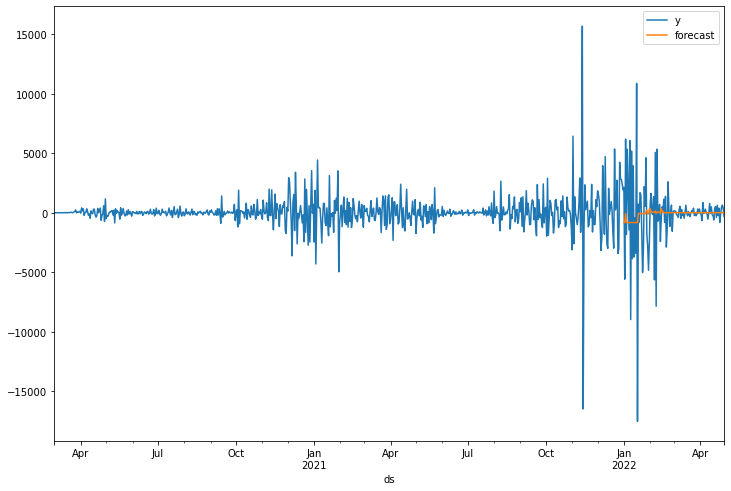

In [19]:
covid_test['forecast'] = reg_model.predict(X_test)

prophet_df_multi = pd.DataFrame(covid_df)

prophet_df_multi['forecast']=covid_test['forecast']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

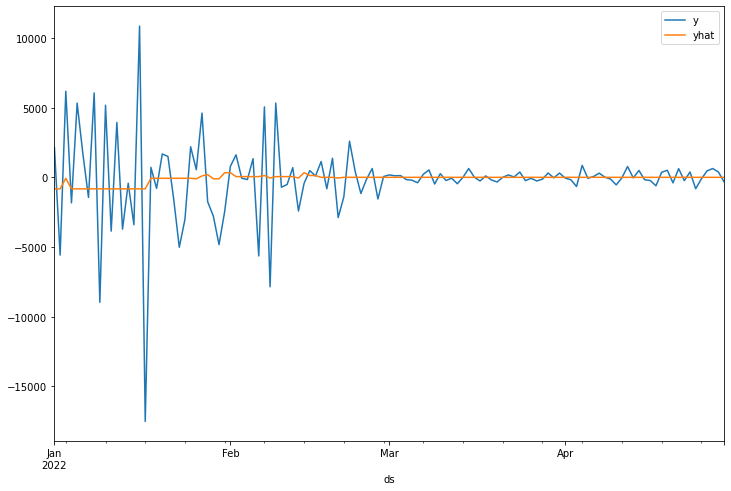

In [20]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = covid_test['forecast'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [21]:
model_rmse = mean_squared_error(covid_test['y'], covid_test['forecast'], squared=False)
model_mae = mean_absolute_error(covid_test['y'], covid_test['forecast'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)
print('MASE = ', mase(covid_test['y'], covid_test['forecast']))

Test RMSE:  2938.676023620743
Test MAE:  1557.6090142706862
MASE =  0.5718165924684252


In [22]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

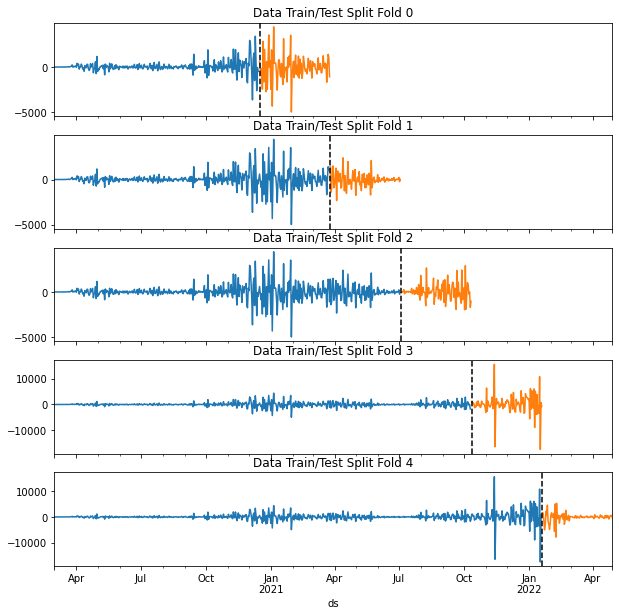

In [23]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_df):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    train['y'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['y'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)
covid_df = covid_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(covid_df):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    TARGET = 'y'

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=20,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)  

[23:24:35] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1372.61101	validation_1-rmse:2951.09023
[29]	validation_0-rmse:1292.52897	validation_1-rmse:2994.24532
[23:24:38] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1372.61101	validation_1-rmse:2951.09023
[30]	validation_0-rmse:1290.06433	validation_1-rmse:2999.31826
[23:24:41] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1372.61101	validation_1-rmse:2951.09023
[30]	validation_0-rmse:1290.06433	validation_1-rmse:2999.31826
[23:24:41] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regress

<AxesSubplot:xlabel='ds'>

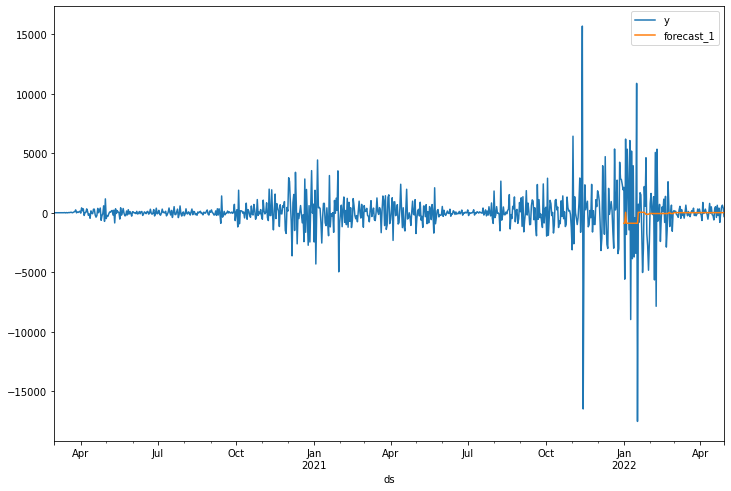

In [25]:
covid_test['forecast_1'] = reg.predict(X_test)

prophet_df_multi = pd.DataFrame(covid_df)

prophet_df_multi['forecast_1']=covid_test['forecast_1']

prophet_df_multi[['y', 'forecast_1']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

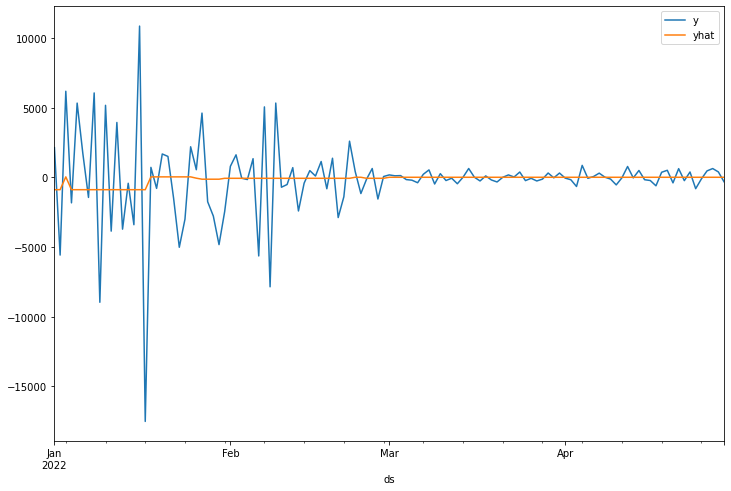

In [26]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = covid_test['forecast_1'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [27]:
model_rmse = mean_squared_error(covid_test['y'], covid_test['forecast'], squared=False)
model_mae = mean_absolute_error(covid_test['y'], covid_test['forecast'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)
print('MASE = ', mase(covid_test['y'], covid_test['forecast']))

Test RMSE:  2938.676023620743
Test MAE:  1557.6090142706862
MASE =  0.5718165924684252
